<a href="https://colab.research.google.com/github/poojadawada/Intracranial-Hemorrhage-Detection/blob/master/Standardized_training_Code_GCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [0]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [0]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2
from keras.models import model_from_json
import tensorflow as tf
import keras

import sys

# from keras_applications.resnet import ResNet50
# Choose any from this list to import - https://keras.io/applications/
from keras.applications.vgg16 import VGG16
from keras_applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import ShuffleSplit

Using TensorFlow backend.


###Declaring Variables

In [0]:
ALL_LABELS = 'project_data/rsna-intracranial-hemorrhage-detection/stage_2_train.csv'
TEST_IMAGES_DIR = 'project_data/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TEST_LABELS = 'project_data/rsna-intracranial-hemorrhage-detection/test.csv'
TRAIN_IMAGES_DIR = 'project_data/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TRAIN_LABELS = 'project_data/rsna-intracranial-hemorrhage-detection/train.csv'
#For Saving
WEIGHTS_SAVE_DIR = 'project_data/rsna-intracranial-hemorrhage-detection/Weights/'
WEIGHT_SAVING_NAME = 'inceptionv3_1_Hidden_lr5e-4-'
#For Loading
SHORTLIST_WEIGHTS_DIR = 'project_data/rsna-intracranial-hemorrhage-detection/Weights_Shortlist/'
WEIGHT_LOAD_NAME = 'inceptionv3_1_Hidden_lr5e-4-10.hdf5'

#Sampling (Between 0 and 1)
KEEP_PROB_0 = 0.1
KEEP_PROB_1 = 0.4

###Train Test Split (Needed to be run only once on a platform)

In [0]:
df = pd.read_csv(ALL_LABELS)
df["Image"] = df["ID"].str.slice(stop=12)
df["Diagnosis"] = df["ID"].str.slice(start=13)    
duplicates_to_remove = [
        56340, 56341, 56342, 56343, 56344, 56345, 56346, 56347, 56348, 56349, 56350, 56351, 1171824, 1171825, 1171826, 1171827, 1171828, 1171829, 1171830, 1171831, 1171832, 1171833, 1171834, 1171835, 3705306, 3705307, 3705308, 3705309, 3705310, 3705311, 3705312, 3705313, 3705314, 3705315, 3705316, 3705317, 3842472, 3842473, 3842474, 3842475, 3842476, 3842477, 3842478, 3842479, 3842480, 3842481, 3842482, 3842483
    ]
    
df = df.drop(index=duplicates_to_remove)
df = df.reset_index(drop=True)
df = df.loc[:, ["Label", "Diagnosis", "Image"]]
df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)

In [0]:
###Caution for Google drive data (Avoid for other platforms)
root_path = 'gdrive/My Drive/RSNA Sample 10 GB attempt 3/'
import os
a = os.listdir(root_path)
a = [item.rstrip('.dcm') for item in a]
df = df.stack().reset_index()
df = df[df['Image'].isin(a)]
df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
len(df)

13062

In [0]:
from sklearn.model_selection import train_test_split
train, test  = train_test_split(df, test_size=0.02, random_state=1)
test = test.stack().reset_index()
test.insert(loc=0, column='ID', value=test['Image'].astype(str) + "_" + test['Diagnosis'])
test = test.drop(["Image", "Diagnosis"], axis=1)
train = train.stack().reset_index()
train.insert(loc=0, column='ID', value=train['Image'].astype(str) + "_" + train['Diagnosis'])
train = train.drop(["Image", "Diagnosis"], axis=1)
print(len(train),len(test))
test.to_csv(TEST_LABELS)
train.to_csv(TRAIN_LABELS)

4426458 90336


###Windowing (BSB & Manual)

In [0]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

In [0]:
def manual_window(dcm, window_center, window_width):
    img = window_image(dcm, window_center, window_width)
    img = (img - (window_center - window_width/2) )/ window_width
    manual_img = np.array([img, img, img]).transpose(1,2,0)

    return manual_img

###Read images (Change Windowing here)

Brain Matter window : W:80 L:40

Blood/subdural window: W:130-300 L:50-100

Soft tissue window: W:350–400 L:20–60

Bone window: W:2800 L:600

Grey-white differentiation window: W:8 L:32 or W:40 L:40

In [0]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
        #img = manual_window(dcm, 40, 80) # Specify window center, window_width here
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img


###Data generator

In [0]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
                 img_dir=TRAIN_IMAGES_DIR, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: KEEP_PROB_0, 1: KEEP_PROB_1})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))#[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

###Loss Function

In [0]:
from keras import backend as K


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


###Model (Change hidden layers here) (Remove cross validation here)

In [0]:

class MyDeepModel:

    
  def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
    self.engine = engine
    self.input_dims = input_dims
    self.batch_size = batch_size
    self.num_epochs = num_epochs
    self.learning_rate = learning_rate
    self.decay_rate = decay_rate
    self.decay_steps = decay_steps
    self.weights = weights
    self.verbose = verbose
    self._build()

  def _build(self):
      
      
    engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                          backend = keras.backend, layers = keras.layers,
                          models = keras.models, utils = keras.utils)
    
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
    out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

    self.model = keras.models.Model(inputs=engine.input, outputs=out)

    self.model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam()) #, metrics=[weighted_loss])
  

  def fit_model(self, train_df, valid_df):
      
    # callbacks
#For kaggle krnel os.chdir to working dir
    checkpointer = keras.callbacks.ModelCheckpoint(filepath=WEIGHTS_SAVE_DIR+WEIGHT_SAVING_NAME+'{epoch:02d}.hdf5' , verbose=1, save_weights_only=True, save_best_only=False, monitor='val_loss')
#Change back to the input directory
    scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
    
    return self.model.fit_generator(
        DataGenerator(
            train_df.index, 
            train_df, 
            self.batch_size, 
            self.input_dims, 
            TRAIN_IMAGES_DIR
        ),
        validation_data = DataGenerator(
            valid_df.index, 
            valid_df, 
            self.batch_size, 
            self.input_dims, 
            TRAIN_IMAGES_DIR
        ),
        epochs=self.num_epochs,
        verbose=self.verbose,
        use_multiprocessing=True,
        workers=4
        #,callbacks=[scheduler]
        #checkpointer
      )

  def save(self, path):
    self.model.save_weights(path)
  
  def load(self, path):
    self.model.load_weights(path)

  def predictions(self, test_df, batch_size_pred=8):
    self.test_df= test_df
    self.batch_size_pred = batch_size_pred
    test_preds = self.model.predict_generator(DataGenerator(self.test_df.index, None, self.batch_size_pred, self.input_dims, TEST_IMAGES_DIR), verbose=1)
    return test_preds


###Read and convert labels dataset to our format (Remove the duplicates when running on GCP)

In [0]:

def read_trainset(filename=TRAIN_LABELS):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_testset(filename=TEST_LABELS):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)

    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df


###Hyperparameters (Most Important Part) - Run this only when training

In [0]:
#To avoid tons of warning that are going to appear in training the model
import warnings
warnings.filterwarnings("ignore")

In [0]:
#Read train set
df = read_trainset()

# train set and validation set (Change number of splits)
ss = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42).split(df.index)

train_idx, valid_idx = next(ss)

# Choose any from this list to import - https://keras.io/applications/ and use as is in engine
# obtain model (Possible values - InceptionV3, VGG16)
model = MyDeepModel(engine=InceptionV3, input_dims=(256, 256, 3), batch_size=32, learning_rate=5e-4,
                    num_epochs=2, decay_rate=0.8, decay_steps=1, weights="imagenet", verbose=1)
#model.load(SHORTLIST_WEIGHTS_DIR+WEIGHT_LOAD_NAME)
history = model.fit_model(df.iloc[train_idx], df.iloc[valid_idx])

Epoch 1/2
12679/18444 [===================>..........] - ETA: 1:35:00 - loss: 0.1195

In [0]:
model.save(WEIGHTS_SAVE_DIR+WEIGHT_SAVING_NAME+".hdf5")

In [0]:
#Plotting
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(history.history["loss"], 'o-')
ax[0].plot(history.history["val_loss"], 'o-')
ax[1].plot(history.history["auc"], 'o-')
ax[1].plot(history.history["val_auc"], 'o-')
ax[2].plot(history.history["lr"], 'o-')


###Loading the model without training

In [0]:
model = MyDeepModel(engine=InceptionV3, input_dims=(256, 256, 3), batch_size=32, learning_rate=5e-4,
                    num_epochs=1, decay_rate=0.8, decay_steps=1, weights="imagenet", verbose=1)
model.load(SHORTLIST_WEIGHTS_DIR+WEIGHT_LOAD_NAME)

###Prediction

In [0]:
#Read test set (No use as of now)
test_df = read_testset(filename=TEST_LABELS)
preds = model.predictions(test_df, batch_size_pred=1)
df_preds = pd.DataFrame(preds, index=test_df.index.values)
df_preds.columns = test_df.columns

2613/2613 [==============================] - 83s 32ms/step


###Precision Recall Curve

In [0]:
Y = np.array(test_df)
Y_pred = np.array(df_preds)

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(6):
    precision[i], recall[i], threshold  = precision_recall_curve(Y[:, i],Y_pred[:, i])
    average_precision[i] = average_precision_score(Y[:, i], Y_pred[:, i])


In [0]:
test_df['Label'].columns

Index(['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'],
      dtype='object', name='Diagnosis')

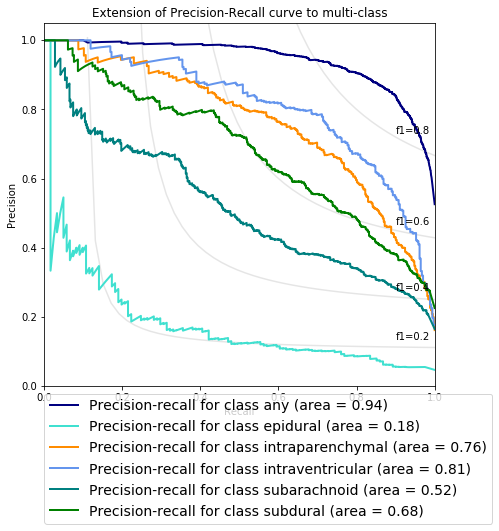

In [0]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal','green','blue','red'])
label = test_df[('Label')].columns
plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))


for i, color in zip(range(6), colors):

    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(label[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

###For Individual class 

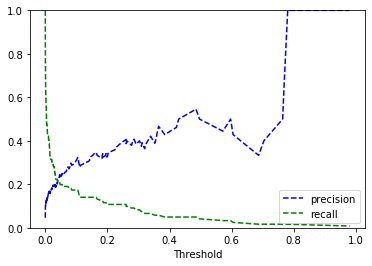

In [0]:
Y = np.array(test_df[('Label','epidural')])
Y_pred = np.array(df_preds[('Label','epidural')])
prec, rec, tre = precision_recall_curve(Y, Y_pred )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
Y_pred_labels = (Y_pred>0.0001).astype(int)
print("True Negative, False Positive")
print(confusion_matrix(Y, Y_pred_labels))
print("False Negative, True Positive")
print("Our aim is to minimize False Negatives")

True Negative, False Positive
[[1338 1154]
 [  20  101]]
False Negative, True Positive
Our aim is to minimize False Negatives
